## 01 - The Garden of Forking Data

**Sources**: 
- [Video: Statistical Rethinking 2023 - 02 - The Garden of Forking Data](https://youtu.be/R1vcdhPBlXA?si=rL3BOz9hHxkPt79m)

#### Imports

In [1]:
# %run init_notebook.py
# %load_ext autoreload
# %autoreload 2

# ruff: noqa: F405
from init_notebook import *

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-01-27T19:44:12.374768+04:00

Python implementation: CPython
Python version       : 3.13.1
IPython version      : 8.31.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas     : 2.2.3
statsmodels: 0.14.4
watermark  : 2.5.0
numpy      : 1.26.4
arviz      : 0.20.0
matplotlib : 3.10.0
xarray     : 2025.1.1
scipy      : 1.15.1
pymc       : 5.20.0



#### Bayesian data analysis

> - For each possible explanation of the sample
> - Count all the ways the sample could occur
> - The explanations with the largest number of ways to produce the observed sample are more plausible

Basis of Applied Probability: Things that can happen more ways are more plausible

The target of inference in Bayesian inference is a posterior probability distribution. Posterior probabilities state the relative numbers of ways each conjectured cause of the data could have produced the data. These relative numbers indicate plausibilities of the different conjectures. These plausibilities are updated in light of observations through Bayesian updating.

More mechanically, a Bayesian model is a composite of variables and distributional definitions for these variables. The probability of the data, often called the likelihood, provides the plausibility of an observation (data), given a fixed value for the parameters. The prior provides the plausibility of each possible value of the parameters, before accounting for the data. The rules of probability tell us that the logical way to compute the plausibilities, after accounting for the data, is to use Bayes’ theorem. This results in the posterior distribution. 

In practice, Bayesian models are fit to data using numerical techniques, like grid approximation, quadratic approximation, and Markov chain Monte Carlo.

### Task: What proportion of earth's surface is covered with water?

#### Workflow (Drawing the Owl)

1. Define **generative model** of tossing the globe
2. Define an **estimand** -- in this case, the proportion of globe covered in water
3. **Design a statistical procedure** to produce an estimate of the estimand
4. **Validate the statistical procedure** (3) using the generative model -- can we recover an accurate estimate of (2) from data generated by (1)
5. **Apply statistical procedure** (3) to real data

#### 1. Define generative model of globe tossing

- $p$: true proportion of water covering the globe -- this is the **estimand**, what we'd like to estimate
- $N$: number of tosses  -- we control this via experiment
- $W$: number of `Water` observations
- $L$: number of `Land` observations

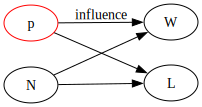

In [2]:
utils.draw_causal_graph(
    edge_list=[
        ("p", "W"),
        ("p", "L"),
        ("N", "L"),
        ("N", "W")
    ],
    graph_direction="LR",
    node_props={
        "p": {"color": "red"}
    },
    edge_props={
        ("p", "W"): {"label": "influence"}
    }
)

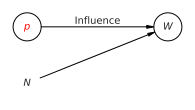

In [3]:
import daft

pgm = daft.PGM()

# Add Nodes
pgm.add_node('p', r'$p$', 0.5, 2, label_params={'color': 'red'})
pgm.add_node('N', r'$N$', 0.5, 1, plot_params={'linewidth': 0})
pgm.add_node('W', r'$W$', 3, 2)

# Add Edges Between Nodes
pgm.add_edge('p', 'W', label='Influence')
pgm.add_edge('N', 'W')

pgm.render();

- This graph defines a **causal model**, of how $p, N$ effect the values of $W, L$. This is the same as saying it defines some function $f$ that maps $p, N$ onto the values of $W, L$, i.e.  
  $$W, L = f(p, N)$$
- Scientific knowledge defines what $f$ is or can be

The unglamourous basis of applied probability:

> Things that can happen more ways are more plausible.

#### 2. Design a statistical procedure to produce an estimate

##### Running Simulation

Following the Bayesian data analysis structure:
- For each possible **proportion of water** on the globe, $p$,
- count all the ways the sample of tosses could have occurred.
- Proportions, $p$, with more ways to produce the sample are more plausible.

The code below simulates and evaluates the likelihood of observing a sequence of outcomes (`observations`, e.g., "WLW") from a globe divided into water (`W`) and land (`L`) regions. The globe can have a configurable number of sides (`resolution`), and the proportion of water varies.

**`plausibility_count(observations, globe)`**:
1. The number of ways to match the observation sequence (`n_ways`).
2. The proportion of water on the globe (`p_water`).

**Steps**:
  1. Convert Strings to Arrays:
     - `observations` and `globe` are converted into NumPy arrays for efficient element-wise operations.
  2. Count Matches:
     - For each observation (`'W'` or `'L'`), the number of matching sides on the globe is counted using `np.sum(globe == obs)`.
     - This produces an array (`ways`) where each element represents the number of ways the corresponding observation can occur.
  3. Compute Total Ways:
     - The product of all values in `ways` represents the total ways to produce the observation sequence. This is calculated in log space (`np.log`) to improve numerical stability, especially for large values.
     - `np.exp` and `np.round` convert the log product back to the total count.
  4. Compute Water Proportion:
     - `p_water` is the proportion of water sides on the globe, calculated as the count of `'W'` divided by the total sides.

Return Values:
  - `n_ways`: The total number of ways to produce the observation sequence.
  - `p_water`: The proportion of water on the globe.

**`toss_simulation(observations, resolution)`**

This function iterates through all possible globe configurations, simulates the observation process, and prints the results.

Steps:
  1. Print Observations:
     - Outputs the input observation sequence (`observations`).
  2. Iterate Over Globe Configurations:
     - For each possible number of water sides (`n_W`), create a globe configuration with `n_W` `'W'` sides and the rest `'L'` sides.
     - Example: For `resolution=4`, the possible configurations are:
       ```
       LLLL, WLLL, WWLL, WWWL, WWWW
       ```
  3. Call `plausibility_count`:
     - Computes `n_ways` (ways to produce the observations) and `p_water` (water proportion) for each configuration.
  4. Store Results:
     - Append `n_ways` and `p_water` to their respective lists.
  5. Print Results:
     - Prints the globe configuration, water proportion, and ways to produce the observations.

In [4]:
def plausibility_count(observations: str, globe: str):
    """
    Calculate the number of ways to observe water ('W') and land ('L') given an observation string and a globe configuration.
    """
    # Convert observation & globe string to an array
    observations = np.array(list(observations.upper()))
    globe = np.array(list(globe))
    
    # Count matches for each observation in globe
    # Tally up ways to obtain each observation given the possible outcomes
    ways = np.array([np.sum(globe == obs) for obs in observations])
    
    # Calculate the total number of ways to produce sample and possible proportion of water
    # perform product in log space for numerical precision
    np.seterr(divide = 'ignore') 
    # Number of ways to produce sample
    n_ways = np.round(np.exp(np.sum(np.log(ways)))).astype(int)
    # Possible proportion of water
    p_water = np.sum(globe == "W") / len(globe) 
    
    return n_ways, p_water

def toss_simulation(observations: str, resolution: int):
    """
    Simulate the number of ways to observe water ('W') for all globe configurations
    of `resolution` sides, varying the proportion of the globe that is covered by water.
    """
    print(f"Observations: '{observations}'")
    n_possible_ways = []
    p_water = []
    
    # Precompute globe configurations
    for n_W in range(resolution + 1):
        n_L = resolution - n_W
        # Conjecture/Parameter: Create n-sided globe with possible outcomes
        globe = "W" * n_W + "L" * n_L
        n_ways, p_w = plausibility_count(observations, globe)
        
        print(f"({n_W+1}) {globe} p(W) = {p_w:.2f}\t\t{n_ways} Ways to Produce")
        n_possible_ways.append(n_ways)
        p_water.append(p_w)
    
    return np.array(n_possible_ways), np.array(p_water)

In [5]:
# Example Usage
RESOLUTION = 4
observations = "WLW"
n_possible_ways, p_water = toss_simulation(observations, resolution=RESOLUTION)

Observations: 'WLW'
(1) LLLL p(W) = 0.00		0 Ways to Produce
(2) WLLL p(W) = 0.25		3 Ways to Produce
(3) WWLL p(W) = 0.50		8 Ways to Produce
(4) WWWL p(W) = 0.75		9 Ways to Produce
(5) WWWW p(W) = 1.00		0 Ways to Produce


![garden_of_forking_data](images/garden_of_forking_data.PNG)

So what good are these counts? By comparing these counts, we have part of a solution for a way to rate the relative plausibility of each conjectured bag composition. But it’s only a part of a solution, because **in order to compare these counts we first have to decide how many ways each conjecture could itself be realized**. We might argue that when we have no reason to assume otherwise, we can just consider each conjecture equally plausible and compare the counts directly. But often we do have reason to assume otherwise.

Suppose we’re willing to say each conjecture is equally plausible at the start. So we just compare the counts of ways in which each conjecture is compatible with the observed data. This comparison suggests that ['W', 'W', 'W', 'L'] is slightly more plausible than ['W', 'W', 'L', 'L'], and both are about three times more plausible than ['W', 'L', 'L', 'L']. Since these are our initial counts, and we are going to update them next, let’s label them **prior**.

**Bayesian (online) Updating**

Suppose we toss the globe again to get another observation: 'W'. Now you have two choices. You could start all over again, making a garden with four layers to trace out the paths compatible with the data sequence ['W', 'L', 'W', 'W']. Or you could take the previous counts—the prior counts—over conjectures (0, 3, 8, 9, 0) and just update them in light of the new observation. It turns out that these two methods are mathematically identical, as long as the new observation is logically independent of the previous observations.

This updating approach amounts to nothing more than asserting that (1) when we have previous information suggesting there are $W_{prior}$ ways for a conjecture to produce a previous observation $D_{prior}$ and (2) we acquire new observations $D_{new}$ that the same conjecture can produce in $W_{new}$ ways, then (3) the number of ways the conjecture can account for both $D_{prior}$ as well as $D_{new}$ is just the product $W_{prior} × W_{new}$.

A Bayesian model begins with one set of plausibilities assigned to each of these possibilities. These are the **prior plausibilities**. Then it updates them in light of the data, to produce the **posterior plausibilities**.

In [6]:
new_observation_possible_ways, _ = toss_simulation("W", resolution=RESOLUTION)

# Online update
n_possible_ways *= new_observation_possible_ways

print("\nUpdated Possibilities given new observation:")
for ii in range(0, RESOLUTION + 1):    
    print(f"({ii+1}) p(W) = {p_water[ii]:1.2}\t\t\t{int(n_possible_ways[ii])} Ways to Produce")

Observations: 'W'
(1) LLLL p(W) = 0.00		0 Ways to Produce
(2) WLLL p(W) = 0.25		1 Ways to Produce
(3) WWLL p(W) = 0.50		2 Ways to Produce
(4) WWWL p(W) = 0.75		3 Ways to Produce
(5) WWWW p(W) = 1.00		4 Ways to Produce

Updated Possibilities given new observation:
(1) p(W) = 0.0			0 Ways to Produce
(2) p(W) = 0.25			3 Ways to Produce
(3) p(W) = 0.5			16 Ways to Produce
(4) p(W) = 0.75			27 Ways to Produce
(5) p(W) = 1.0			0 Ways to Produce


**The whole sample**

In [7]:
RESOLUTION = 4
observations = "WLWWWLWLW"
n_W = len(observations.replace("L", ""))
n_L = len(observations) - n_W

n_possible_ways, p_water = toss_simulation(observations, resolution=RESOLUTION)

Observations: 'WLWWWLWLW'
(1) LLLL p(W) = 0.00		0 Ways to Produce
(2) WLLL p(W) = 0.25		27 Ways to Produce
(3) WWLL p(W) = 0.50		512 Ways to Produce
(4) WWWL p(W) = 0.75		729 Ways to Produce
(5) WWWW p(W) = 1.00		0 Ways to Produce


##### Analytical Solution

- A single toss of the globe has a probability $p$ of producing a water ($W$) observation. It has a probability $1−p$ of producing a land ($L$) observation. 
- Each toss of the globe is independent of the others.

We can get identical answers with an analytical solution:

Results suggest the following analytical solution 
$$W,L = (Rp)^W \times ((1 - p)R)^L$$
where $R$ is the number of possible globes, in this case 4

In [8]:
def plausibility_count(p, n_W, n_L, resolution=RESOLUTION):
    """
    p:          proportion of water 
    n_w:        number of water observations in the sample
    n_l:        number of land observations in sample
    resolution: number of globe sides
    """
    return (resolution * p) ** n_W * (resolution - resolution * p) ** n_L

In [9]:
RESOLUTION = 4
observations = np.array(list("WLWWWLWLW"))
n_W = len(observations[observations == 'W'])
n_L = len(observations) - n_W

n_possible_ways = np.vectorize(plausibility_count)(p_water, n_W, n_L)

##### Probability

**From counts to probability**. It is helpful to think of this strategy as adhering to a principle of honest ignorance: *When we don’t know what caused the data, potential causes that may produce the data in more ways are more plausible*. This leads us to count paths through the garden of forking data. We’re counting the implications of assumptions.

We define the updated plausibility of each possible composition of the bag, after seeing the data, as:

<center>Plausibility of ['W', 'L', 'L', 'L'] after seeing ['W', 'L', 'W']</center>

$$\propto$$

<center>ways ['W', 'L', 'L', 'L'] can produce ['W', 'L', 'W']</center>

$$\times$$

<center>prior plausibility ['W', 'L', 'L', 'L']</center>

We want to compare the plausibility of each possible composition. So it’ll be helpful to define $p$ as the proportion of the earth that is water. For ['W', 'L', 'L', 'L'], $p = 1/4 = 0.25$

We can not write:

plausibility of $p$ after $D_{new}$ $\propto$ ways $p$ can produce $D_{new}$ $\times$ prior plausibility of $p$

The above just means that for any value $p$ can take, we judge the plausibility of that value $p$ as proportional to the number of ways it can get through the garden of forking data.

- non-negative values that sum to 1
- normalizes large sums by the total counts

We construct probabilities by standardizing the plausibility so that the sum of the plausibilities for all possible conjectures will be one. All you need to do in order to standardize is to add up all of the products, one for each value p can take, and then divide each product by the sum of products:

$$\text{plausibility of } p \text{ after } D_{new} = \frac{\text{ways }p\text{ can produce } D_{new} \times \text{prior plausibility }p}{\text{sum of products}}$$

In [10]:
n_possible_probabilities = n_possible_ways / n_possible_ways.sum()

print("Proportion\tWays\tProbability\tBars")
for p, n_w, n_p in zip(p_water, n_possible_ways, n_possible_probabilities):
    print(f"{p:1.12}\t\t{n_w:0.0f}\t{n_p:1.3f}\t\t{'#'*int(20*n_p):<20}")

Proportion	Ways	Probability	Bars
0.0		0	0.000		                    
0.25		27	0.021		                    
0.5		512	0.404		########            
0.75		729	0.575		###########         
1.0		0	0.000		                    


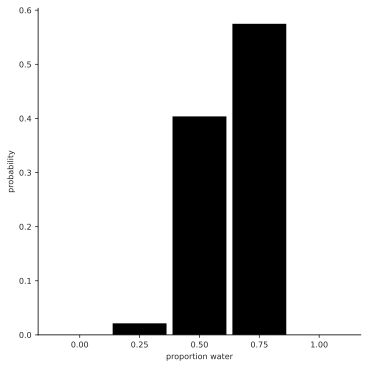

In [11]:
probs = np.linspace(0, 1, RESOLUTION+1)
plt.subplots(figsize=(5, 5))
plt.bar(x=probs, height=n_possible_probabilities, width= .9 / RESOLUTION, color='k')
plt.xticks(probs);
plt.ylabel("probability")
plt.xlabel("proportion water");

These plausibilities are also probabilities—they are non-negative (zero or positive) real numbers that sum to one. 

- A conjectured proportion of water on earth, $p$, is usually called a **parameter** value. It’s just a way of indexing possible explanations of the data.
- The relative number of ways that a value $p$ can produce the data is usually called a **likelihood**. It is derived by enumerating all the possible data sequences that could have happened and then eliminating those sequences inconsistent with the data.
- The prior plausibility of any specific $p$ is usually called the **prior probability**.
- The new, updated plausibility of any specific $p$ is usually called the **posterior probability**.

#### 3. Validate Statistical Procedure using Generative Model

**Test Before You Est(imate) 🐤**
1. Code generative simulation (1)
2. Code an estimator (2)
3. Test (3) with (1); you should get expected output

##### (1) Generative Simulation

In [12]:
from pprint import pprint

def sim_globe(p: float = 0.7, N: int = 9) -> list[str]:
    """Simulate N globe tosses with a specific/known proportion
    p: float
        The propotion of water
    N: int
        Number of globe tosses
    """
    return np.random.choice(list("WL"),  size=N, p=np.array([p, 1-p]), replace=True)

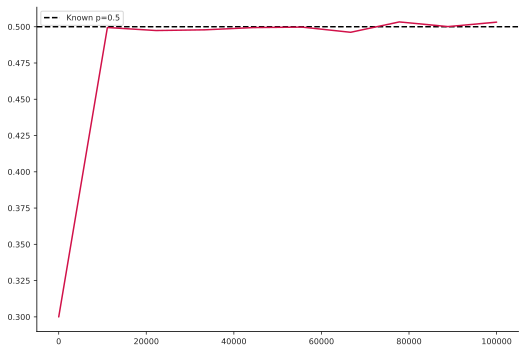

In [13]:
known_p = 0.5

simulated_ps = []
sample_sizes = np.linspace(10, 100_000, 10)
for N in sample_sizes:
    simulated_p = np.sum(sim_globe(p=known_p, N=int(N)) == 'W') / N
    simulated_ps.append(simulated_p)

plt.axhline(known_p, label=f"Known p={known_p}", color='k', linestyle='--')
plt.legend()
plt.plot(sample_sizes, simulated_ps);

##### (2) Code the estimator

The estimator takes in observations and returns a probability distribution (posterior) over potential estimates. Higher probability estimates should be more plausible given the data.

In [14]:
def compute_posterior(sample, resolution=RESOLUTION):
    if isinstance(sample, str):
        sample = np.array(list(sample))
    n_W = len(sample[sample == 'W'])
    n_L = len(sample) - n_W
    
    p_water = np.linspace(0, 1, resolution + 1)
    n_possible_ways = np.vectorize(plausibility_count)(p_water, n_W, n_L, resolution)
    posterior = n_possible_ways / n_possible_ways.sum()
    
    return posterior, p_water

In [15]:
def plot_posterior(observations, resolution=RESOLUTION, ax=None):
    posterior, probs = compute_posterior(observations, resolution=resolution)
    if ax is not None:
        plt.sca(ax)
    plt.bar(x=probs, height=posterior, width= .9 / resolution, color='k')
    # plt.xticks(probs[::2], rotation=45)
    plt.ylabel("probability")
    plt.xlabel("proportion water")
    plt.ylim(0,1)
    plt.title(f"Posterior Calculated from # Samples: {len(observations)}");

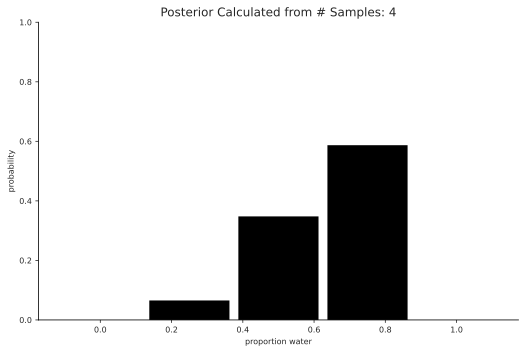

In [16]:
observations = 'WLWW'
plot_posterior(observations, resolution=4)

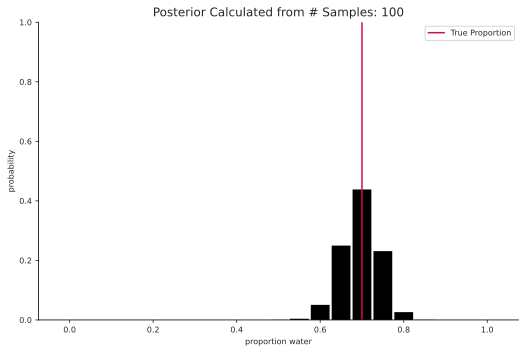

In [17]:
np.random.seed(5)
known_p = .7
simulated_observations = sim_globe(p=known_p, N=100)
plot_posterior(simulated_observations, resolution=20)
plt.axvline(known_p, color='C0', label='True Proportion')
plt.legend();

#### Infinite Possibilities

Moving from an N-sided globe to an infinitely-sided globe.

As we increase resolution of globe
- there are more bars/finer-grained resolution along the proportion axis
- bars get shorter with more possibilities -- they must sum to 1

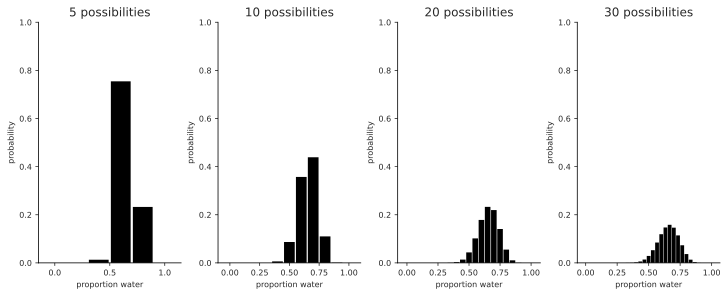

In [18]:
np.random.seed(12)
known_p = .7
simulated_observations = sim_globe(p=known_p, N=30)
_, axs = plt.subplots(1, 4, figsize=(10, 4))
for ii, possibilities in enumerate([5, 10, 20, 30]):
    plot_posterior(simulated_observations, resolution=possibilities, ax=axs[ii])
    axs[ii].set_title(f"{possibilities} possibilities")

##### Binomial & Beta Distribution

Once we add our assumptions that (1) every toss is independent of the other tosses and (2) the probability of W is the same on every toss, probability theory provides a unique answer, known as the binomial distribution. This is the common “coin tossing” distribution. And so the probability of observing $W$ waters and $L$ lands, with a probability $p$ of water on each toss, is:

$$
\text{Posterior probability of }p = Pr(W,L \mid p) = \frac{(W + L + 1)!}{W!L!} p^W(1-p)^L
$$

*The function is read as*: The counts of “water” $W$ and “land’ $L$ are distributed binomially, with probability $p$ of “water” on each toss

This is an analytical function that gives us the pdf as the limit as number of possibilities $\rightarrow \infty$, where $\frac{(W + L + 1)!}{W!L!}$ is a normalizing constant to make the distribution sum to 1.

Probability density function (pdf) for beta is $f(x, a, b)$, where $a = W + 1$ and $b = L + 1$.

Probability mass function:

$$Pr(W \mid n, p) =  \frac{n!}{W!(n − W)!} p^W (1 − p)^{n−W}$$


The probability of observing specified W’s in $n$ tosses — below a value of $p$.

That number is the relative number of ways to get six water, holding $p$ at 0.5 and $N =W +L$ at nine. So it does the job of counting relative number of paths through the garden

In [19]:
# Binomial Distribution - likelihood of six W’s in nine tosses — under 0.5 value of p
stats.binom.pmf(6, 9, 0.5)

0.16406250000000003

In [20]:
from scipy.special import factorial

def beta_posterior(n_W: int, n_L: int, p: float) -> float:
    """
    Calculates the beta posterior over proportions `p` given a set of
    `N_W` water and `N_L` land observations
    """
    return factorial(n_W + n_L + 1) / (factorial(n_W) * factorial(n_L)) * p ** n_W * (1-p) ** n_L

In [21]:
# Beta distribution 
stats.beta.pdf(0.5, 6+1, 3+1)
beta_posterior(6, 3, 0.5)

1.640625

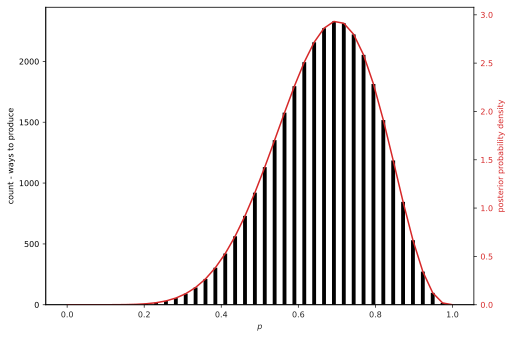

In [22]:
p = np.linspace(0, 1, 40)

fig, ax1 = plt.subplots()

color = 'black'
ax1.set_xlabel('$p$')
ax1.set_ylabel('count - ways to produce', color=color)
ax1.bar(p, plausibility_count(p, 7, 3), color=color, width=0.01)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:red'
ax2.set_ylabel('posterior probability density', color=color) 
ax2.plot(p, beta_posterior(7, 3, p), color=color)
# ax2.plot(p, stats.beta.pdf(p, 7+1, 3+1), color=color)
# ax2.plot(p, stats.binom.pmf(7, 10, p), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,)

ax2.spines[['right', 'top']].set_visible(True)

fig.tight_layout() 
plt.show()

The observed variables $W$ and $L$ are given relative counts through the binomial distribution. So we can write, as a shortcut:

$$W \sim \text{Binomial}(N,p)$$

where $N =W +L$. The above is just a convention for communicating the assumption that the relative counts of ways to realize $W$ in $N$ trials with probability $p$ on each trial comes from the binomial distribution. 

The unobserved parameter p similarly gets:

$$p \sim \text{Uniform}(0,1)$$

This means that p has a uniform—flat—prior over its entire possible range, from zero to one. This is obviously not the best we could do, since we know the Earth has more water than land, even if we do not know the exact proportion yet.

##### Tossing the Globe

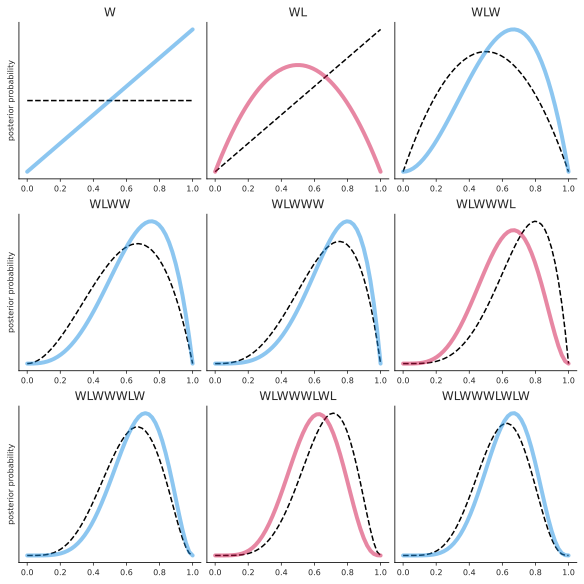

In [23]:
def plot_beta_posterior_from_observations(observations: str, resolution: int = 50, **plot_kwargs) -> None:
    """Calculates and plots the beta posterior for a string of observations"""
    n_W = len(observations.replace("L", ""))
    n_L = len(observations) - n_W
    proportions = np.linspace(0, 1, resolution)
        
    probs = beta_posterior(n_W, n_L, proportions)
    plt.plot(proportions, probs, **plot_kwargs)
    plt.yticks([])
    plt.title(observations)

# Tossing the globe
observations = "WLWWWLWLW"
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for ii in range(9):
    ax = axs[ii // 3][ii % 3]
    plt.sca(ax)
    # Plot previous
    if ii > 0:
        plot_beta_posterior_from_observations(observations[:ii], color='k', linestyle='--')
    else:
        # First observation, no previous data
        plot_beta_posterior_from_observations('', color='k', linestyle='--')
        
    color = 'C1' if observations[ii] == 'W' else 'C0'
    plot_beta_posterior_from_observations(observations[:ii+1], color=color, linewidth=4, alpha=.5)
    
    if not ii % 3:
        plt.ylabel("posterior probability")

The dashed horizontal line represents this initial plausibility of each possible value of $p$. After seeing the first toss, which is a “W”, the model updates the plausibilities to the solid line. The plausibility of $p=0$ has now fallen to exactly zero—the equivalent of “impossible.” Why? Because we observed at least one speck of water on the globe, so now we know there is some water. The model executes this logic automatically. You don’t have it instruct it to account for this consequence. Probability theory takes care of it for you, because it is essentially counting paths through the garden of forking data.

Likewise, the plausibility of $p >0.5$ has increased. This is because there is not yet any evidence that there is land on the globe, so the initial plausibilities are modified to be consistent with this. Note however that the relative plausibilities are what matter, and there isn’t yet much evidence. So the differences in plausibility are not yet very large. In this way, the amount of evidence seen so far is embodied in the plausibilities of each value of $p$.

Every time a “$W$” is seen, the peak of the plausibility curve moves to the right, towards larger values of $p$. Every time an “$L$” is seen, it moves the other direction. The maximum height of the curve increases with each sample, meaning that fewer values of $p$ amass more plausibility as the amount of evidence increases. As each new observation is added, the curve is updated consistent with all previous observations.

This updating process works backwards, as well as forwards. Given the final set of plausibilities in the bottom-right plot, and knowing the final observation (W), it is possible to mathematically divide out the observation, to infer the previous plausibility curve. 

#### From Prior to Posterior

Once you have named all the variables and chosen definitions for each, a Bayesian model can update all of the prior distributions to their purely logical consequences: the **posterior distribution**. For every unique combination of data, likelihood, parameters, and prior, there is a unique posterior distribution. This distribution contains the relative plausibility of different parameter values, conditional on the data and model. The posterior distribution takes the form of the probability of the parameters, conditional on the data. In this case, it would be $Pr(p \mid W,L)$, the probability of each possible value of $p$, conditional on the specific W and L that we observed.

**Probability Rules Summary**:

- [Sum Rule, Product Rule, Joint & Marginal Probability](https://www.youtube.com/watch?v=xjLqawhT3bY)

**Sum Rule**:

$$P(X)=\sum_Y P(X,Y)$$

$$P(Y)=\sum_X P(X,Y)$$

**Product Rule**:

$$P(X,Y) = P(Y \mid X)P(X)$$

$$P(Y,X) = P(X \mid Y)P(Y)$$

**Bayes' Rule**:

$$P(Y \mid X) = \frac{P(X \mid Y)P(Y)}{P(X)}$$

$$P(X \mid Y) = \frac{P(Y \mid X)P(X)}{P(Y)}$$

**Bayes' Theorem**

The mathematical definition of the posterior distribution arises from Bayes’ theorem.

The **joint probability** of the data $W$ and $L$ and any particular value of $p$ is: 
$$Pr(W, L, p) = Pr(W, L \mid p)Pr(p)$$

This just says that the probability of $W$, $L$ and $p$ is the product of $Pr(W,L \mid p)$ and the prior probability $Pr(p)$. This is like saying that the probability of rain and cold on the same day is equal to the probability of rain, when it’s cold, times the probability that it’s cold. This much is just definition. But it’s just as true that:

$$Pr(W, L, p) = Pr(p \mid W, L)Pr(W,L)$$

This is just the reverse of which probability is conditional, on the right-hand side. It is still a true definition. It’s like saying that the probability of rain and cold on the same day is equal to the probability that it’s cold, when it’s raining, times the probability of rain.

Now since both right-hand sides above are equal to the same thing, $Pr(W,L,p)$, they are also equal to one another:

$$Pr(W, L \mid p)Pr(p) = Pr(p \mid W, L)Pr(W,L)$$

So we can now solve for the thing that we want, $Pr(p|W,L)$:

$$Pr(p \mid W, L) = \frac{Pr(W, L \mid p)Pr(p)}{Pr(W,L)}$$

This is Bayes’ theorem. It says that the probability of any particular value of $p$, considering the data, is equal to the product of the relative plausibility of the data, conditional on $p$, and the prior plausibility of $p$, divided by this thing $Pr(W,L)$, which I’ll call the average probability of the data.

$$\text{Posterior} = \frac{\text{Probability of the data} \times \text{Prior}}{\text{Average Probability of the data}}$$

The **average probability of the data**, $Pr(W,L)$, can be confusing. It is commonly called the **“evidence”** or the “**average likelihood**,” neither of which is a transparent name. The probability Pr(W,L)is literally the average probability of the data. Averaged over what? Averaged
over the prior. It’s job is just to standardize the posterior, to ensure it sums (integrates) to
one. In mathematical form:

$$Pr(W,L) = E(Pr(W,L \mid p)) = \int Pr(W,L\mid p)Pr(p)dp$$

The operator $E$ means to take an *expectation*. Such averages are commonly called *marginals* in mathematical statistics, and so you may also see this same probability called a *marginal likelihood*. And the integral above just defines the proper way to compute the average over a continuous distribution of values, like the infinite possible values of $p$.

The key lesson is that the **posterior is proportional to the product of the prior and the probability of the data**. Why? Because for each specific value of p, the number of paths through the garden of forking data is the product of the prior number of paths and the new number of paths. Multiplication is just compressed counting. The average probability on the bottom just standardizes the counts so they sum to one. So while Bayes’ theorem looks complicated, because the relationship with counting paths is obscured, it just **expresses the counting that logic demands**.


In [24]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(5, grid_points)

def truncated_prior(grid_points, trunc_point=0.5):
    """
    Returns Truncated prior density

            Parameters:
                grid_points (numpy.array): Array of prior values
                trunc_point (double): Value where the prior is truncated

            Returns:
                density (numpy.array): Truncated density of prior values
    """
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)


def double_exp_prior(grid_points):
    """
    Returns Double Exponential prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Double Exponential density of prior values
    """
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))


def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    successes (int): Number of successes
                    tosses (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    likelihood (numpy.array): array of likelihood at each point in the grid
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, likelihood, posterior

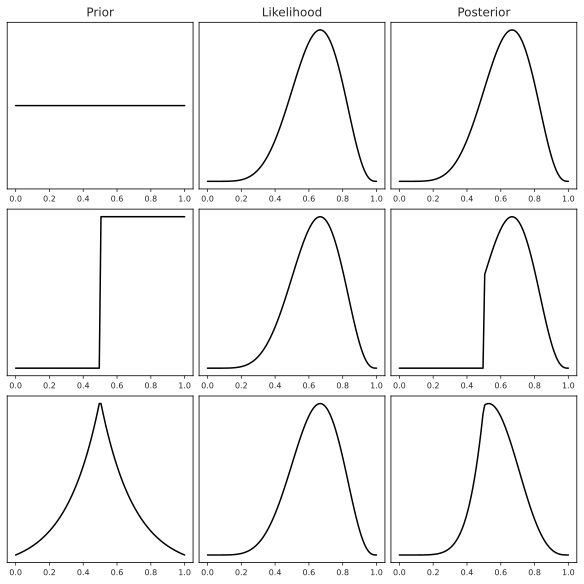

In [25]:
w, n = 6, 9

priors = [uniform_prior, truncated_prior, double_exp_prior]
titles = ['Prior', 'Likelihood', 'Posterior']

_, axs = plt.subplots(3, 3, figsize=(8, 8))
for ii in range(3):
    ax = axs[ii]   
    p_grid, likelihood, posterior = binom_post_grid_approx(priors[ii], 100, w, n)
    ax[0].plot(p_grid, priors[ii](100), "k-")
    ax[1].plot(p_grid, likelihood, "k-")
    ax[2].plot(p_grid, posterior, "k-")
    for i in range(3):
        ax[i].axes.get_yaxis().set_visible(False)
        ax[i].spines[['right', 'top']].set_visible(True)
        if ii == 0:
            ax[i].set_title(f"{titles[i]}")        

The posterior distribution as a product of the prior distribution and likelihood. Top: A flat prior constructs a posterior that is simply proportional to the likelihood. Middle: A step prior, assigning zero probability to all values less than 0.5, results in a truncated posterior. Bottom: A peaked prior that shifts and skews the posterior, relative to the likelihood.

The plot illustrates the multiplicative interaction of a prior and a probability of data. On each row, a prior on the left is multiplied by the probability of data in the middle to produce a posterior on the right. The probability of data in each case is the same. The priors however vary. As a result, the posterior distributions vary.

#### Conditioning Engines

The Bayesian model is a machine and it has built-in definitions for the likelihood, the parameters, and the prior. And then at its heart lies a motor that processes data, producing a posterior distribution. The action of this motor can be thought of as conditioning the prior on the data. As explained in the previous section, this conditioning is governed by the rules of probability theory, which defines a uniquely logical posterior for set of assumptions and observations.

However, knowing the mathematical rule is often of little help, because many of the interesting models in contemporary science cannot be conditioned formally, no matter your skill in mathematics. And while some broadly useful models like linear regression can be conditioned formally, this is only possible if you constrain your choice of prior to special forms that are easy to do mathematics with. We’d like to avoid forced modeling choices of this kind, instead favoring conditioning engines that can accommodate whichever prior is most useful for inference.

What this means is that various numerical techniques are needed to approximate the mathematics that follows from the definition of Bayes’ theorem. In this book, you’ll meet three different conditioning engines, numerical techniques for computing posterior distributions:

1) Grid approximation
2)  Quadratic approximation
3) Markov chain Monte Carlo (MCMC)

##### Grid Approximation

One of the simplest conditioning techniques is grid approximation. While most parameters are continuous, capable of taking on an infinite number of values, it turns out that we can achieve an excellent approximation of the continuous posterior distribution by considering only a finite grid of parameter values. At any particular value of a parameter, $p'$, it’s a simple matter to compute the posterior probability: just multiply the prior probability of $p'$ by the likelihood at $p'$. Repeating this procedure for each value in the grid generates an approximate picture of the exact posterior distribution. This procedure is called **grid approximation**.

Grid approximation will mainly be useful as a pedagogical tool, as learning it forces the user to really understand the nature of Bayesian updating. But in most of your real modeling, grid approximation isn’t practical. The reason is that it scales very poorly, as the number of parameters increases. So in later chapters, grid approximation will fade away, to be replaced by other, more efficient techniques. 

In the context of the globe tossing problem, grid approximation works extremely well. So let’s build a grid approximation for the model we’ve constructed so far. Here is the recipe:

1) Define the grid. This means you decide how many points to use in estimating the posterior, and then you make a list of the parameter values on the grid.
2) Compute the value of the prior at each parameter value on the grid.
3) Compute the likelihood at each parameter value.
4) Compute the unstandardized posterior at each parameter value, by multiplying the prior by the likelihood.
5) Finally, standardize the posterior, by dividing each value by the sum of all values.

In [26]:
def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    successes (int): Number of successes
                    tosses (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    likelihood (numpy.array): array of likelihood at each point in the grid
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, likelihood, posterior

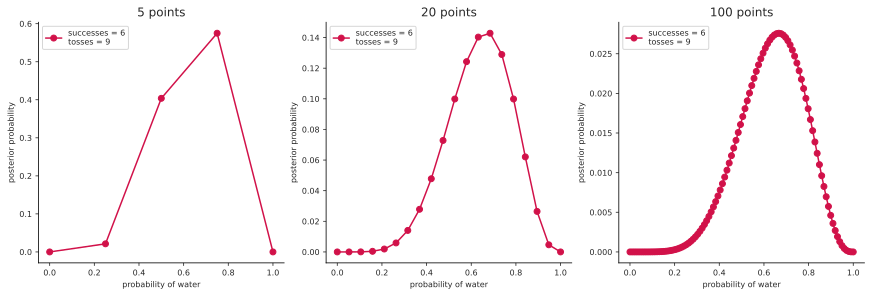

In [27]:
w, n = 6, 9

points = (5, 20, 100)

_, ax = plt.subplots(1, len(points), figsize=(4 * len(points), 4))
for idx, ps in enumerate(points):
    p_grid, _, posterior = binom_post_grid_approx(uniform_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

##### Quadratic Approximation

We’ll stick with the grid approximation to the globe tossing posterior, for the first few exercises. But before long you’ll have to resort to another approximation, one that makes stronger assumptions. The reason is that the number of unique values to consider in the grid grows rapidly as the number of parameters in your model increases. For the single-parameter globe tossing model, it’s no problem to compute a grid of 100 or 1000 values. But for two parameters approximated by 100 values each, that’s already $100^{2} =10,000$ values to compute. For 10 parameters, the grid becomes many billions of values. These days, it’s routine to have models with hundreds or thousands of parameters. The grid approximation strategy scales very poorly with model complexity, so it won’t get us very far.

A useful approach is **quadratic approximation**. Under quite general conditions, the region near the peak of the posterior distribution will be nearly Gaussian—or “normal”—in shape. This means the posterior distribution can be usefully approximated by a Gaussian distribution. A Gaussian distribution is convenient, because it can be completely described by only two numbers: the location of its center (**mean**) and its spread (**variance**).

A **Gaussian approximation** is called “quadratic approximation” because the logarithm of a Gaussian distribution forms a parabola. And a parabola is a quadratic function. So this approximation essentially represents any log-posterior with a parabola.

For many of the most common procedures in applied statistics—linear regression, for example—the approximation works very well. Often, it is even exactly correct, not actually an approximation at all. Computationally, quadratic approximation is very inexpensive, at least compared to grid approximation and MCMC (discussed next). The procedure contains two steps.

1) Find the posterior mode. This is usually accomplished by some optimization algorithm, a procedure that virtually “climbs” the posterior distribution, as if it were a mountain. The algorithm doesn’t know where the peak is, but it does know the slope under its feet. There are many well-developed optimization procedures, most of them more clever than simple hill climbing. But all of them try to find peaks.
2) Once you find the peak of the posterior, you must estimate the curvature near the peak. This curvature is sufficient to compute a quadratic approximation of the entire posterior distribution. In some cases, these calculations can be done analytically, but usually your computer uses some numerical technique instead.

In [28]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_approximation:
    p = pm.Uniform("p", 0, 1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
    mean_q = pm.find_MAP()

    # Remove transform from the variable `p`
    normal_approximation.rvs_to_transforms[p] = None

    # Change name so that we can use `mean_q["p"]` value
    p_value = normal_approximation.rvs_to_values[p]
    p_value.name = p.name
    
    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]
    
    # Compute the 89% percentile interval
    norm = stats.norm(mean_q, std_q)
    prob = 0.89
    z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
    pi = mean_q["p"] + std_q * z    

    # display summary of quadratic approximation
    print("\tMean\tStDev\t5.5%\t94.5% ")
    print(f"p\t{mean_q['p']:.3f}\t{std_q[0]:.3f}\t{pi[0]:.3f}\t{pi[1]:.3f}")

Output()

	Mean	StDev	5.5%	94.5% 
p	0.667	0.157	0.416	0.918


A Hessian is a square matrix of second derivatives. It is used for many purposes in mathematics, but in the quadratic approximation it is second derivatives of the log of posterior probability with respect to the parameters. It turns out that these derivatives are sufficient to describe a Gaussian distribution, because the logarithm of a Gaussian distribution is just a parabola. Parabolas have no derivatives beyond the second, so once we know the center of the parabola (the posterior mode) and its second derivative, we know everything about it. And indeed the second derivative (with respect to the outcome) of the logarithm of a Gaussian distribution is proportional to its **inverse squared standard deviation** (its “precision”). So knowing the standard deviation tells us everything about its shape.

The standard deviation is typically computed from the Hessian, so computing the Hessian is nearly always a necessary step. For now it’s enough to recognize the term and associate it with an attempt to find the standard deviation for a quadratic approximation.


We have presented a brief summary of the quadratic approximation. In this case, it shows the posterior mean value of p =0.67, which it calls the “Mean.” The curvature is labeled “StdDev” This stands for standard deviation. This value is the standard deviation of the posterior distribution, while the mean value is its peak. Finally, the last two values in the output show the 89% percentile interval, which you’ll learn more about later. You can read this kind of approximation like: *Assuming the posterior is Gaussian, it is maximized at 0.67, and its standard deviation is 0.16*.

Since we already know the posterior, let’s compare to see how good the approximation is. We will use the analytical approach here, which uses `stats.beta.pdf`.

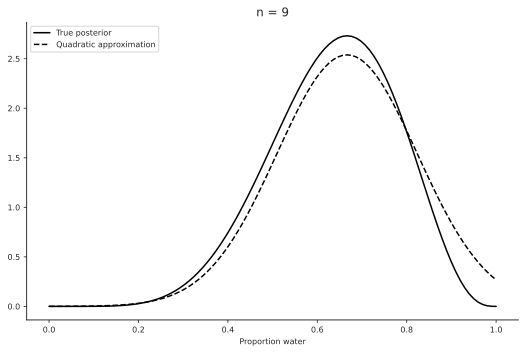

In [29]:
# analytical posterior calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)

plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), color='k', label="True posterior")

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), color='k', linestyle='--', label="Quadratic approximation")
plt.legend(loc=2)

plt.title(f"n = {n}")
plt.xlabel("Proportion water");

Output()

Output()

Output()

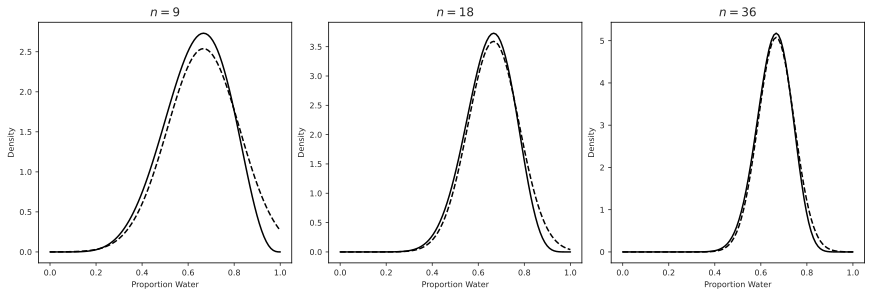

In [30]:
# Figure 2.8
x = np.linspace(0, 1, 100)
w, n = [6, 12, 24], [9, 18, 36]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for idx, ps in enumerate(zip(w, n)):
    data = np.repeat((0, 1), (ps[1] - ps[0], ps[0]))
    with pm.Model() as normal_approximation:
        p = pm.Uniform("p", 0, 1)  # uniform priors
        w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
        mean_q = pm.find_MAP()

        normal_approximation.rvs_to_transforms[p] = None
        p_value = normal_approximation.rvs_to_values[p]
        p_value.name = p.name
        
        std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

    ax[idx].plot(x, stats.beta.pdf(x, ps[0] + 1, ps[1] - ps[0] + 1), color='k')
    ax[idx].plot(x, stats.norm.pdf(x, mean_q["p"], std_q), color='k', linestyle='--')
    ax[idx].spines[['right', 'top']].set_visible(True)
    ax[idx].set_xlabel("Proportion Water")
    ax[idx].set_ylabel("Density")
    ax[idx].set_title(r"$n={}$".format(ps[1]))

Accuracy of the quadratic approximation. In each plot, the exact posterior distribution is plotted in solid curve, and the quadratic approximation is plotted as the dotted curve. Left: The globe tossing data with $n=9$ tosses and $w=6$ waters. Middle: Double the amount of data, with the same fraction of water, $n=18$ and $w=12$. Right: Four times as much data, $n=36$ and $w=24$.

The quadratic approximation curve does alright on its left side, but looks pretty bad on its right side. It even assigns positive probability to $p=1$, which we know is **impossible**, since we saw at least one land sample.

As the amount of data increases, however, the quadratic approximation gets better. In the middle plot, the sample size is doubled to $n =18$ tosses, but with the same fraction of water, so that the mode of the posterior is in the same place. The quadratic approximation looks better now, although still not great. At quadruple the data, on the right side of the figure, the two curves are nearly the same now.

This phenomenon, where the quadratic approximation improves with the amount of data, is very common. It’s one of the reasons that so many classical statistical procedures are nervous about small samples: Those procedures use quadratic (or other) approximations that are only known to be safe with infinite data. Often, these approximations are useful with less than infinite data, obviously. But the rate of improvement as sample size increases varies greatly depending upon the details. In some models, the quadratic approximation can remain terrible even with thousands of samples.

Using the quadratic approximation in a Bayesian context brings with it all the same concerns. But you can always lean on some algorithm other than quadratic approximation, if you have doubts. Indeed, grid approximation works very well with small samples, because in such cases the model must be simple and the computations will be quite fast. You can also use MCMC, which is introduced next.

##### Maximum likelihood estimation

The quadratic approximation, either with a uniform prior or with a lot of data, is often equivalent to a **maximum likelihood estimate** (MLE) and its **standard error**. The MLE is a very common non-Bayesian parameter estimate. This correspondence between a Bayesian approximation and a common non-Bayesian estimator is both a blessing and a curse. It is a blessing, because it allows us to reinterpret a wide range of published non-Bayesian model fits in Bayesian terms. It is a curse, because maximum likelihood estimates have some curious drawbacks, and the quadratic approximation can share them. We’ll explore these drawbacks later, they are one of the reasons we’ll turn to Markov chain Monte Carlo.

##### Markov Chain Monte Carlo (MCMC)

There are lots of important model types, like multilevel (mixed-effects) models, for which neither grid approximation nor quadratic approximation is always satisfactory. Such models may have hundreds or thousands or tens-of-thousands of parameters. Grid approximation routinely fails here, because it just takes too long. Special forms of quadratic approximation might work, if everything is just right. But commonly, something is not just right. Furthermore, multilevel models do not always allow us to write down a single, unified function for the posterior distribution. This means that the function to maximize (when finding the MAP) is not known, but must be computed in pieces.

As a result, various counterintuitive model fitting techniques have arisen. The most popular of these is Markov chain Monte Carlo (MCMC), which is a family of conditioning engines capable of handling highly complex models.

The conceptual challenge with MCMC lies in its highly non-obvious strategy. Instead of attempting to compute or approximate the posterior distribution directly, MCMC techniques merely draw samples from the posterior. You end up with a collection of parameter values,and the frequencies of these values correspond to the posterior plausibilities. You can then build a picture of the posterior from the histogram of these samples.

We nearly always work directly with these samples, rather than first constructing some mathematical estimate from them. And the samples are in many ways more convenient than having the posterior, because they are easier to think with.

The below code implements a simple **Metropolis-Hastings algorithm**, a Markov Chain Monte Carlo (MCMC) method, to approximate the posterior distribution of a probability parameter $p$, given a likelihood defined by a binomial model.

**Key Components**:
1. **Inputs**:
   - `W = 6`: Number of "wins" (successes).
   - `L = 3`: Number of "losses" (failures).
   - `n_samples = 1000`: Total number of samples to generate for the Markov chain.
   - Initial probability, `p[0] = 0.5`.

2. **Model**:
   - $p$ represents the probability of success (e.g., win rate) in a binomial distribution. The algorithm explores possible values for $p$ to estimate its posterior distribution.
   - The likelihood is computed using the binomial probability mass function (`stats.binom.pmf`).

3. **Proposal Distribution**:
   - A new candidate value, $p_{\text{new}}$, is proposed at each step, sampled from a normal distribution centered at the current value $p[i-1]$ with a small standard deviation (`0.1`).

4. **Reflection Boundary**:
   - To ensure $p_{\text{new}}$ stays in the valid range \([0, 1]\):
     - If $p_{\text{new}} < 0$, it is reflected back: $p_{\text{new}} = -p_{\text{new}}$.
     - If $p_{\text{new}} > 1$, it is reflected back: $p_{\text{new}} = 2 - p_{\text{new}}$.

5. **Acceptance Step**:
   - The acceptance ratio, $\frac{q_1}{q_0}$, is calculated, where:
     - $q_0$: Likelihood of observing `W` successes given $p[i-1]$.
     - $q_1$: Likelihood of observing `W` successes given $p_{\text{new}}$.
   - A random number from a uniform distribution is drawn, and if it is less than $\frac{q_1}{q_0}$, the new value is accepted ($p[i] = p_{\text{new}}$). Otherwise, the chain retains the previous value ($p[i] = p[i-1]$).

**Outcome**:
- The algorithm generates a sequence of 1000 samples (`p`) that approximate the posterior distribution of the probability parameter $p$.
- Over many iterations, the chain will converge to the posterior distribution of $p$, allowing statistical inference about the probability of success given the observed data ($W = 6$, $L = 3$).

This is a simple example of Bayesian inference using MCMC to estimate a posterior distribution for a parameter in a binomial model.

In [31]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

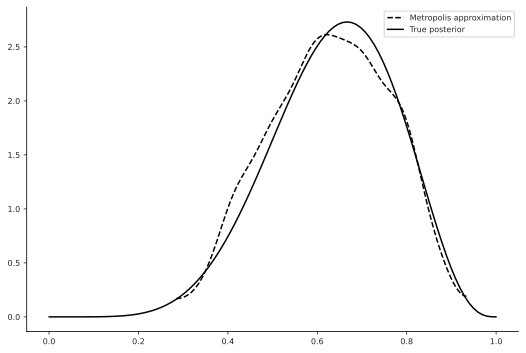

In [32]:
az.plot_kde(p, label="Metropolis approximation", plot_kwargs={'color': 'black', 'linestyle': '--'})
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), color='k', label="True posterior")
plt.legend();

#### From Posterior to Prediction

- To make predictions, we must average (i.e. integrate) over the entire posterior -- this averages over the uncertainty in the posterior
- We could do this with integral calculus
- OR, we could just **take samples from the posterior and average over those**

**Note**: Turn a calculus problem into a data summary problem

##### On Bayesian Inference

- **There is no minimun sample size** -- fewer samples fall back to prior
- **Posterior shape embodies the sample size** -- more data makes the posterior more precise
- There is no point estimates -- **the estimate is the entire posterior distribution**
- There is no true interval -- there are an infinite number of intervals one could draw, each is arbitrary and depends on what you're trying to communicate/summarize

##### Sampling from Posterior Distribution

In [33]:
# Parameters
n_W, n_L = 6, 3
N = n_W + n_L

a, b = 1 + n_W, 1 + n_L # alpha and beta of posterior

n_samples = 1000  # Number of samples
size = 9  # Binomial size (number of tosses)

p_range = np.linspace(0, 1, 100)

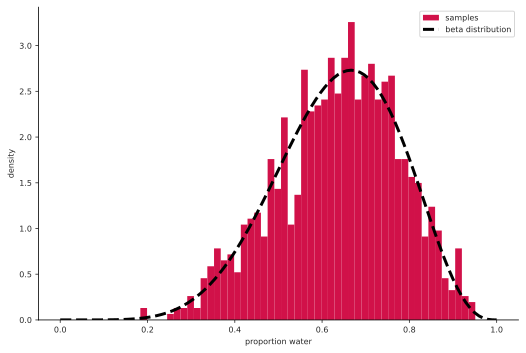

In [34]:
# draw random samples from Beta PDF
beta_posterior_pdf = stats.beta(a, b)
beta_posterior_samples = beta_posterior_pdf.rvs(size=n_samples)

# Show that our beta postorior captures shape of beta-distributed samples
plt.hist(beta_posterior_samples, bins=50, density=True, label='samples');
plt.plot(p_range, beta_posterior(a-1, b-1, p_range), linewidth=3, color='k', linestyle='--', label='beta distribution')
plt.xlabel("proportion water")
plt.ylabel("density")
plt.legend();

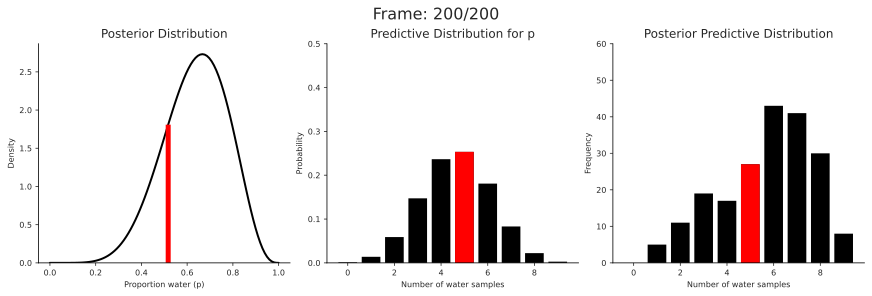

In [35]:
from matplotlib.animation import FuncAnimation

# Initialize variables for animation
posterior_predictive = np.zeros(size + 1)               # Accumulated posterior predictive distribution
p_samples = []                                          # Store sampled p values

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Function to update the animation for each frame
def update(frame):
    global posterior_predictive, p_samples
    
    # Clear all axes for the new frame
    for ax in axes:
        ax.clear()
    
    # Sample from Beta posterior
    p = stats.beta.rvs(a,b)
    p_samples.append(p)
    
    # Sample from Binomial distribution
    w = stats.binom.rvs(size, p)
    posterior_predictive[w] += 1                        # Accumulate frequency of w

    # Posterior distribution
    axes[0].plot(p_range, stats.beta.pdf(p_range, a, b), 
                 'k-', linewidth=2)                     # Full posterior beta distribution beta.pdf(p, a, b)
    axes[0].vlines(x=p, ymin=0, ymax=stats.beta.pdf(p, a, b), 
                   color='red', linewidth=5)            # Highlight the current sampled p
    axes[0].set_title('Posterior Distribution')
    axes[0].set_xlabel('Proportion water (p)')
    axes[0].set_ylabel('Density')
    axes[0].set_ylim(0,)

    # Predictive distribution for the current p
    binom_probs = stats.binom.pmf(np.arange(size + 1), size, p)
    axes[1].bar(np.arange(size + 1), binom_probs, color='k')
    axes[1].bar(w, binom_probs[w], color='red')         # Highlight the sampled water count
    axes[1].set_title('Predictive Distribution for p')
    axes[1].set_xlabel('Number of water samples')
    axes[1].set_ylabel('Probability')
    axes[1].set_ylim(0,0.5)

    # Posterior predictive distribution (accumulated)
    axes[2].bar(np.arange(size + 1), posterior_predictive, color='k')
    axes[2].bar(w, posterior_predictive[w], color='red') # Highlight the current water count
    axes[2].set_title('Posterior Predictive Distribution')
    axes[2].set_xlabel('Number of water samples')
    axes[2].set_ylabel('Frequency')
    axes[2].set_ylim(0,60)

    # Add frame number
    fig.suptitle(f'Frame: {frame + 1}/{n_frames}', fontsize=16)

# Create the animation
n_frames = 200                                          # Total number of frames
ani = FuncAnimation(fig, update, frames=n_frames, repeat=False, interval=50)

# Save or display the animation
ani.save('posterior_predictive_animation.mp4', writer='ffmpeg', fps=10)

plt.show()

The simulation demonstrates **Bayesian posterior and prior predictive distributions**:

1. **Bayesian Updating**:  
   - The posterior distribution $P(p | \text{data})$ is updated using observed data (6 water, 3 land) and a prior belief (Beta(1,1)).
   - The simulation samples $p$ from the posterior distribution $Beta(a, b)$, showing how evidence refines our belief about $p$.

2. **Posterior Predictive Checks**:  
   - Predicting future data based on posterior samples of $p$.  
   - The middle plot shows the sampling distribution of outcomes ($W$) given a specific sampled $p$ (likelihood).

3. **Accumulated Posterior Predictive Distribution**:  
   - The rightmost plot aggregates predictions over multiple posterior samples, representing the range of plausible future outcomes under the posterior.

4. **MCMC-like Simulation**:  
   - The process mimics a **Markov Chain Monte Carlo (MCMC)** approach:
     - Sampling $p$ (parameter space).
     - Simulating $w$ (data space) based on $p$.
     - Repeating this many times to approximate distributions of interest.
   - This highlights how Bayesian inference relies on sampling to explore posterior and predictive distributions, especially when analytical solutions are infeasible.

In summary, the simulation demonstrates **how Bayesian inference uses observed data to update beliefs about parameters** (posterior) and **predict future data** (posterior predictive), which are key principles of Bayesian data analysis and MCMC methods.

**Predictive Distribution**:

The horizontal axis here goes from zero to nine and we count the number of water samples in those nine tosses, so the possibilities are from zero to nine and each of the black bars here shows the relative number of ways to get that particular value of $w$ on the horizontal axis out of a very large number of experiments of tossing the globe nine times this is called the predictive distribution. This comes from the `sim_globe` function but applied over infinite 'resolutions'.

##### Sampling from Posterior Predictive Distribution

**Posterior Prediction**: a prediction for out-of-sample data based on the current posterior estimate
- 1. Draw a sample of model parameters from the posterior (i.e. proportions)
- 2. Generate/simulate data predictions using our generative model and the sampled parameters
- 3. The resulting probability distribution is our prediction

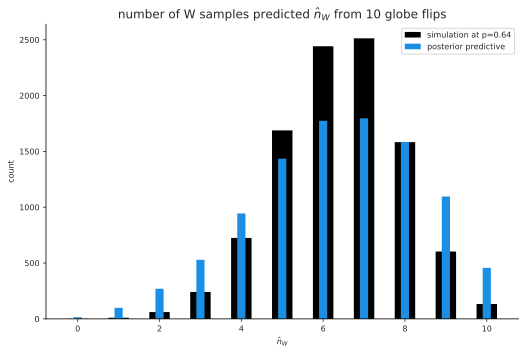

In [36]:
# 1. Sample parameters values from posterior
N_posterior_samples = 10_000
posterior_samples = beta_posterior_pdf.rvs(size=N_posterior_samples)

# 2. Use samples for the posterior to simulate sampling 10 observations from our generative model
N_draws_for_prediction = 10
posterior_predictive = [(sim_globe(p, N_draws_for_prediction) == 'W').sum() for p in posterior_samples]
# Using stats.binom.rvs instead of 'sim_globe'
# posterior_predictive = stats.binom.rvs(N_draws_for_prediction, posterior_samples)
ppd_unique, ppd_counts = np.unique(posterior_predictive, return_counts=True)

# ...for comparison we can compare to the distribution that results from pinning the parameter to a specific value
specific_prob = 0.64
specific_predictive = [(sim_globe(specific_prob, N_draws_for_prediction) == 'W').sum() for _ in posterior_samples]
# specific_prob = np.full((N_posterior_samples,), 0.64)
# specific_predictive = stats.binom.rvs(N_draws_for_prediction, specific_prob)
specific_unique, specific_counts = np.unique(specific_predictive, return_counts=True)

plt.bar(specific_unique, specific_counts, width=.5, color='k', label=f'simulation at p={specific_prob:1.2}');
plt.bar(ppd_unique, ppd_counts, width=.2, color='C1', label='posterior predictive');
plt.xlabel("$\hat n_W$")
plt.ylabel('count')
plt.title(f"number of W samples predicted $\hat n_W$ from {N_draws_for_prediction} globe flips")
plt.legend();

### Practice Problems

1) *The probability of rain on Monday*:
   -  Pr(rain|Monday) 
   -  Pr(rain,Monday)/Pr(Monday) = Pr(rain|Monday) 

2) Pr(Monday|rain):
   - The probability that it is Monday, given that it is raining

3) The probability that it is Monday, given that it is raining:
   - Pr(Monday|rain)
   - Pr(rain|Monday)Pr(Monday)/Pr(rain): the product Pr(rain|Monday) Pr(Monday) is just the joint probability of rain and Monday, Pr(rain,Monday). Then dividing by the probability of rain provides the conditional probability
4) Compute and plot the grid approximate posterior distribution for each of the following sets of observations. In each case, assume a uniform prior for $p$.

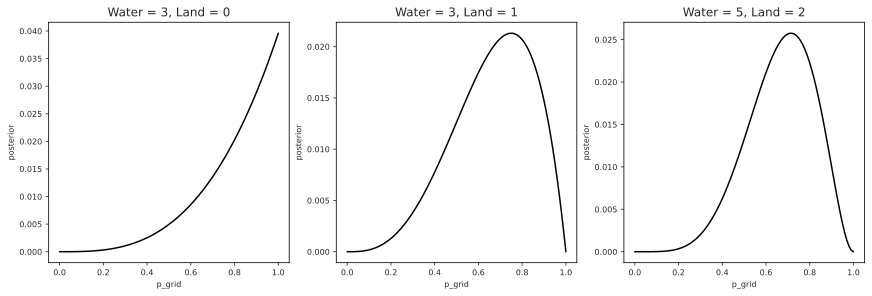

In [37]:
# W, W, W             - (3,3)
# W, W, W, L          - (3,4)
# L, W, W, L, W, W, W - (5,7)

tosses = [(3,3), (3,4), (5, 7)]
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for idx, (w, n) in enumerate(tosses):
    p_grid, _, posterior = binom_post_grid_approx(uniform_prior, 100, w, n)
    ax[idx].plot(p_grid, posterior, "k-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("p_grid")
    ax[idx].set_ylabel("posterior")
    ax[idx].set_title(f"Water = {w}, Land = {n-w}")
    ax[idx].spines[['right', 'top']].set_visible(True)

5. Now assume a prior for p that is equal to zero when $p <0.5$ and is a positive constant when $p ≥ 0.5$. Again compute and plot the grid approximate posterior distribution for each of the sets of observations in the problem just above.

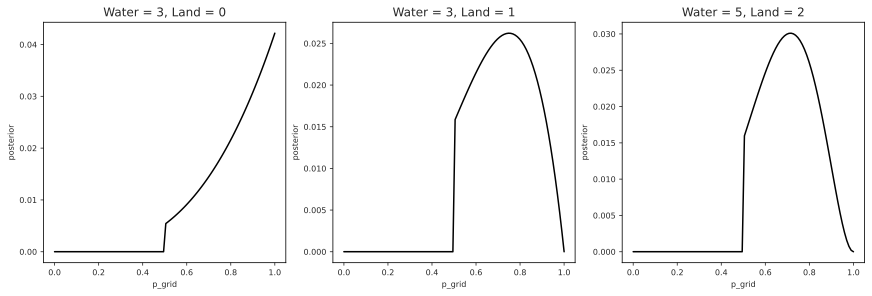

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for idx, (w, n) in enumerate(tosses):
    p_grid, _, posterior = binom_post_grid_approx(truncated_prior, 100, w, n)
    ax[idx].plot(p_grid, posterior, "k-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("p_grid")
    ax[idx].set_ylabel("posterior")
    ax[idx].set_title(f"Water = {w}, Land = {n-w}")
    ax[idx].spines[['right', 'top']].set_visible(True)

6. Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know which—was tossed in the air and produced a “land” observation. Assume that each globe was equally likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on seeing “land” (Pr(Earth|land)), is 0.23.

![prob-tree](images\earth-mars-probability-tree.png)

$P(Land, Earth) = P(Earth)P(Land \mid Earth) = 0.5 \times 0.3 = 0.15$

$P(Land, Mars) = P(Mars)P(Land \mid Mars) = 0.5 \times 1 = 0.5$

$P(Land) = P(Land, Earth) + P(Land, Mars) = 0.15 + 0.5 = 0.65$

$P(Earth \mid Land) = \frac{P(Land \mid Earth)P(Earth)}{P(Land)} = \frac{0.3 \times 0.5}{0.65} \approx 0.23$

We can think of $P(Land)$ as the marginal (average) probability of land, averaging over the two globes.

You can think of this **posterior probability** as an **updated prior**. The prior probability was 0.5. Since there is more land coverage on Mars than on Earth, the posterior probability after observing land is smaller than the prior.

7. Suppose you have a deck with only three cards. Each card has two sides, and each side is either black or white. One card has two black sides. The second card has one black and one white side. The third card has two white sides. Now suppose all three cards are placed in a bag and shuffled. Someone reaches into the bag and pulls out a card and places it flat on a table. A black side is shown facing up, but you don’t know the color of the side facing down. Show that the probability that the other side is also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This means counting up the ways that each card could produce the observed data (a black side facing up on the table)

p = probability of 'B'

Observed: 'B'
- ['B', 'B'], p(B) = 1.0, ways to produce = 2
- ['B', 'W'], p(B) = 0.5, ways to produce = 1
- ['W', 'W'], p(B) = 0.0, ways to produce = 0

Total Ways to produce black side up = 2 + 1 + 0 = 3

Way to produce B/B = 2

2/3 probability that the other side is black

![3-deck-card](images/3-deck-card.png)

$P(B-Card \mid B) = \frac{P(B \mid B-Card)P(B-Card)}{P(B)} = \frac{1 \times 1/3}{(1/3 \times 1/2) + 1/3} = 2/3$

8. Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is drawn from the bag and a black side appears face up. Again calculate the probability that the other side is black.

Observed: 'B'
- ['B', 'B'], p(B) = 1.0, ways to produce = 2
- ['B', 'B'], p(B) = 1.0, ways to produce = 2
- ['B', 'W'], p(B) = 0.5, ways to produce = 1
- ['W', 'W'], p(B) = 0.0, ways to produce = 0

Total Ways to produce black side up = 2 + 2 + 1 + 0 = 5

Way to produce B/B = 2 + 2 = 4

4/5 probability that the other side is black

With the extra B/B card, there are now 5 ways to see a black card face up: 2 from the first B/B card, 1 from the B/W card, and 2 more from the other B/B card. 4 of these ways are consistent with a B/B card, so the probability is now 4/5 that the other side of the card is also black.

![4-deck-card](images/4-deck-card.png)

$P(B-Card \mid B) = \frac{P(B \mid B-Card)P(B-Card)}{P(B)} = \frac{1 \times 1/2}{(1/4 \times 1/2) + 1/2} = 4/5$

9. Imagine that black ink is heavy, and so cards with black sides are heavier than cards with white sides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume there are three cards: B/B, B/W, and W/W. After experimenting a number of times, you conclude that for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that the probability the other side is black is now 0.5. Use the counting method, as before.

Observed: 'B'
- ['B', 'B'], p(B) = 1.0, prior count = 2, likelihood = 1, new count = 2*1
- ['B', 'W'], p(B) = 0.5, prior count = 1, likelihood = 2, new count = 1*2
- ['W', 'W'], p(B) = 0.0, prior count = 0, likelihood = 3, new count = 0*3

Total Ways to produce black side up = 2 + 2 + 0 = 4

Way to produce B/B = 2

1/2 probability that the other side is black

This problem introduces uneven numbers of ways to draw each card from the bag. So while in the two previous problems we could treat each card as equally likely, prior to the observation, now we need to employ the prior odds explicitly. 

There are still 2 ways for B/B to produce a black side up, 1 way for B/W, and zero ways for W/W. But now there is 1 way to get the B/B card, 2 ways to get the B/W card, and 3 ways to get the W/W card. So there are, in total, 1 ×2 =2 ways for the B/B card to produce a black side up and 2 × 1 = 2 ways for the B/W card to produce a black side up. This means there are 4 ways total to see a black side up, and 2 of these are from the B/B card. 2/4 ways means probability 0.5.

10. Assume again the original card problem, with a single card showing a black side face up. Before looking at the other side, we draw another card from the bag and lay it face up on the table. The face that is shown on the new card is white. Show that the probability that the first card, the one showing a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat this like the sequence of globe tosses, counting all the ways to see each observation, for each possible first card.

Observed: 'B'
- ['B', 'B'], p(B) = 1.0, ways to produce = 2
- ['B', 'W'], p(B) = 0.5, ways to produce = 1
- ['W', 'W'], p(B) = 0.0, ways to produce = 0

Total Ways to produce black side up = 2 + 1 + 0 = 3

Way to produce B/B = 2

2/3 **prior probability** that the other side is black

Observed New: 'W'
- ['B', 'B'], p(B) = 1.0, ways to produce = 0
- ['B', 'W'], p(B) = 0.5, ways to produce = 1
- ['W', 'W'], p(B) = 0.0, ways to produce = 2

Total Ways to produce white side up = 0 + 1 + 2 = 3

Given that the first draw has at least 1 side black and the second draw has at least 1 side white, the first draw cannot be card W/W and second card cannot be B/B. Either the first draw is B/W or B/B or the second draw is B/W or W/W. 

Observing (1) B then (2) W
- Scenario 1: **B**/**B** then B/**W** or **W**/**W** = 2 * 3 = 6 
- Scenario 2: **B**/W then **W**/**W** = 1 * 2 = 2

Ways to create the sequence = 6 + 2 = 8

Posterior probability of sequence where B/B is first draw = 6/8 = 0.75

The observation is now the sequence: black side up then white side up. We’re still interested in the probability the other side of the first card is black. Let’s take each possible card in turn. 

First the B/B card. There are $2$ ways for it to produce the first observation, the black side up. This leaves the B/W card and W/W card to produce the next observation. Each card is equally likely (has same number of ways to get drawn from the bag). But the B/W card has only $1$ way to produce a white side up, while the W/W card has $2$ ways. So $3$ ways in total to get the second card to show white side up. All together, assuming the first card is B/B, there are $2×3=6$ ways to see the BW sequence of sides up. 

Now consider the B/W card being drawn first. There is $1$ way for it to show black side up. This leaves the B/B and W/W cards to produce the second side up. B/B cannot show white up, so zero ways there. W/W has $2$ ways to show white up. All together, that’s $1×2=2$ ways to see the sequence BW, when the first card is B/W. The final card, W/W, cannot produce the sequence when drawn first. So zero ways. Now let’s bring it all together. Among all three cards, there are $6+2=8$ ways to produce the sequence BW. $6$ of these are from the B/B being drawn first. So that’s $6/8=0.75$ probability that the first card is B/B.

11. Suppose there are two species of panda bear. Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins 10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise birthing singleton infants. Assume these numbers are known with certainty, from many years of field research. Now suppose you are managing a captive panda breeding program. You have a new female panda of unknown species, and she has just given birth to twins. What is the probability that her next birth will also be twins?

To solve this problem, realize first that it is asking for a conditional probability:
$$P(Twins_{2} \mid Twins_{1})$$

the probability the second birth is twins, conditional on the first birth being twins. Remember the definition of conditional probability:
$$P(Twins_{2} \mid Twins_{1})=\frac{P(Twins_{1}, Twins_{2})}{P(Twins)}$$

So our job is to define $P(Twin_{1}, Twin_{2})$, the joint probability that both births are twins, and $P(Twins)$, the unconditioned probability of twins. 

$P(Twins)$ is easier, so let’s do that one first. The “unconditioned” probability just means that we have to average over the possibilities. In this case, that means the species have to averaged over. The problem implies that both species are equally common, so there’s a half chance that any given panda is of either species. This gives us

$$P(Twins) = 0.5(0.1) + 0.5(0.2) = 0.15$$

Now for $P(Twins_{1},Twins_{2})$. The probability that a female from species A has two sets of twins is $0.1 ×0.1 =0.01$. The corresponding probability for species B is $0.2×0.2 =0.04$. Averaging over species identity:

$$P(Twins_{1}, Twins_{2}) = 0.5(0.01) + 0.5(0.04) = 0.025$$

Finally, we combine these probabilities to get the answer:
$$P(Twins_{2} \mid Twins_{1}) = \frac{0.025}{0.15} = \frac{1}{6} \approx 0.17$$

Note that this is higher than $P(twins)$. This is because the first set of twins provides some information about which species we have, and this information was automatically used in the calculation.

12. Recall all the facts from the problem above. Now compute the probability that the panda we have is from species A, assuming we have observed only the first birth and that it was twins.

$$P(Species_{A} \mid Twins) = \frac{P(Twins \mid Species_{A})P(Species_{A})}{P(Twins)}$$

This can be computed using the values obtained from earlier:

$$P(Species_{A} \mid Twins) = \frac{0.1 \times 0.5}{0.15} = \frac{1}{3} \approx 0.33$$

So the posterior probability of species A, after observing twins, falls to 1/3, from a prior probability of 1/2. This also implies a posterior probability of 2/3 that our panda is species B, since we are assuming only two possible species.

13. Continuing on from the previous problem, suppose the same panda mother has a second birth and that it is not twins, but a singleton infant. Compute the posterior probability that this panda is species A.

Given the new information, we are computing 

$$\text{Posterior} = \frac{\text{Probability of the data} \times \text{Prior}}{\text{Average Probability of the data}}$$

Recall that Bayes’ theorem accumulates evidence, using Bayesian updating. So we can take the posterior probabilities from the previous problem and use them as prior probabilities in this problem. This implies $P(A)=1/3$. Now we can ignore the first observation, the twins, and concern ourselves with only the latest observation, the singleton birth. The previous observation is embodied in the prior, so there’s no need to account for it again.

The probability of this data for a species A pandas is $P(Singleton \mid Species_A) = 0.9$.

Whereas, the prior is the probability computed earlier $P(Species_{A} \mid Twins) = \frac{1}{3}$.

The average/marginal probability of the data = $P(Singleton) = P(Singleton \mid (Species_{A} \mid Twins))P(Species_{A} \mid Twins) + P(Singleton \mid (Species_{B} \mid Twins))P(Species_{B} \mid Twins)$. 

Given that $P(Species_{A} \mid Twins) = 1/3$, $P(Species_{B} \mid Twins) = 1 - 1/3$

Therefore, 
$$P(Singleton) = P(Singleton \mid A)P(A) + P(Singleton \mid B)P(B) = (0.9)\times\frac{1}{3} + (0.8)\times\frac{2}{3} = \frac{5}{6}$$

Combining everything, we get: 
$$P(A\mid Singleton)= \frac{(0.9)(1/3)}{5/6}=\frac{9}{25} = 0.36$$

This is a modest increase in posterior probability of species A, an increase from about 0.33 to 0.36.

The other way to proceed is to go back to the original prior, Pr(A)=0.5, before observed any births. Then you can treat both observations (twins, singleton) as data and update the original prior. I’m going to start abbreviating “twins” as T and “singleton” as S. The formula:

$$P(A\mid T, S) = \frac{P(T,S \mid A)P(A)}{P(T,S)}$$

Let’s start with the average likelihood, $P(T, S)$, because it will force us to define the likelihoods anyway:

$$P(T,S) = P(T,S \mid A)P(A) + P(T,S \mid B)P(B)$$

The first likelihood is just the probability a species A mother has twins and then a singleton:

$$P(T,S \mid A) = (0.1)(0.9) = 0.09$$

And the second likelihood is similar, but for species B:

$$P(T,S \mid B) = (0.2)(0.8) = 0.16$$

The priors are both 0.5, so all together:
$$P(T,S) = (0.09)(0.5) + (0.16)(0.5) = 0.125$$

We already have the likelihood needed for the numerator, so we can go to the final answer now:

$$P(A\mid T, S) = \frac{(0.09)(0.5)}{0.125} = 0.36$$


14. A common boast of Bayesian statisticians is that Bayesian inference makes it easy to use all of the data, even if the data are of different types. So suppose now that a veterinarian comes along who has a new genetic test that she claims can identify the species of our mother panda. But the test, like all tests, is imperfect. This is the information you have about the test:
    - The probability it correctly identifies a species A panda is 0.8.
    - The probability it correctly identifies a species B panda is 0.65.
  
    The vet administers the test to your panda and tells you that the test is positive for species A. First ignore your previous information from the births and compute the posterior probability that your panda is species A. Then redo your calculation, now using the birth data as well.

|        | Species A | Species B |
|--------|-----------|-----------|
| Test A | 0.8       | 0.2       |
| Test B | 0.35      | 0.65      |

Posterior Probability That Panda is Species A:

- $P(A) = 0.5$
- $P(Test_A \mid A) = 0.8$
- $P(Test_A \mid B) = 1 - 0.65 = 0.35$ (False Negative)

We use the original prior, Pr(A)=0.5. Plugging everything into Bayes’ theorem:

$$P(A \mid Test_A) = \frac{(0.8)(0.5)}{(0.8)(0.5)+(0.35)(0.5)} \approx 0.7$$

So the test has increased the confidence in species A from 0.5 to 0.7.

Now to use the birth information as well. The easiest way to do this is just to begin with the posterior from the previous problem. That posterior already used the birth data, so if we adopt it as our prior, we automatically use the birth data. And so our prior becomes Pr(A)=0.36. Then the approach is just the same as just above:

$$P(A \mid Test_A) = \frac{P(Test_A \mid A)P(A)}{P(Test_A)}$$

$$P(A \mid Test_A) = \frac{(0.8)(0.36)}{(0.36)(0.8) + (1-0.36)(0.35)} \approx 0.56$$

And since this posterior uses all of the data, the two births and the genetic test, it would be honest to label it as $P(A|Test_A, Twins, Singleton) \approx 0.56$.
